In [24]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K
from tensorboard.plugins.hparams import api as hp

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
X_train_normalized, X_test_normalized = X_train / 255.0, X_test / 255.0

## Model (sklearn)

In [5]:
X_train_normalized_reshaped, X_test_normalized_reshaped = X_train_normalized.reshape(X_train.shape[0], -1), X_test_normalized.reshape(X_test.shape[0], -1)

In [6]:
X_train_normalized_reshaped.shape, X_test_normalized_reshaped.shape

((50000, 3072), (10000, 3072))

In [10]:
train_mask = np.random.choice(2, X_train_normalized_reshaped.shape[0], p=[0.9, 0.1])
test_mask = np.random.choice(2, X_test_normalized_reshaped.shape[0], p=[0.9, 0.1])

X_train_normalized_reshaped = X_train_normalized_reshaped[train_mask == 1]
y_train = y_train[train_mask == 1]

X_test_normalized_reshaped = X_test_normalized_reshaped[test_mask == 1]
y_test = y_test[test_mask == 1]

In [11]:
X_train_normalized_reshaped.shape, X_test_normalized_reshaped.shape

((5011, 3072), (973, 3072))

In [12]:
params = [
    {
        "C": [1, 10, 100, 1000, 10000],
        "kernel": ["linear"],
    },
    {
        "C": [1, 10, 100, 1000, 10000],
        "kernel": ["poly"],
        "degree": [3, 5, 7],
    },
    {
        "C": [1, 10, 100, 1000, 10000],
        "kernel": ["rbf"],
        "gamma": ["auto", "scale"]
    },
]

In [13]:
clf = GridSearchCV(svm.SVC(), params, verbose=7, n_jobs=-1, cv=3)
clf.fit(X_train_normalized_reshaped, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 80.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000, 10000], 'degree': [3, 5, 7],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000, 10000],
                          'gamma': ['auto', 'scale'], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=7)

In [14]:
clf.cv_results_

{'mean_fit_time': array([ 84.13018481,  82.74805371,  85.21089069,  83.32584429,
         82.8511827 ,  82.52063131,  69.17637142,  61.8635424 ,
         77.90500323,  64.925186  ,  59.27606773,  74.98744154,
         63.15618078,  57.10148851,  77.57143084,  62.04139829,
         57.02438442,  73.87445752,  62.25901437,  56.59079456,
         87.22254928,  78.7047348 ,  71.10518463, 103.35362832,
         68.6614356 , 105.3166248 ,  81.00193397, 103.46636009,
         79.061294  , 102.83608389]),
 'mean_score_time': array([30.07447052, 30.38491917, 30.16480581, 30.52212199, 30.17049829,
        29.56842375, 27.71297503, 26.88520392, 28.78639952, 29.09983381,
        26.18164738, 28.31643693, 26.80183983, 25.93973557, 28.54438678,
        26.67143766, 25.93880796, 28.20690497, 27.4442571 , 25.79255128,
        30.76157093, 30.49309015, 31.86722883, 30.97100711, 30.20723311,
        31.11293197, 29.78612359, 30.8853368 , 29.90445638, 30.44392832]),
 'mean_test_score': array([0.30812439,

In [15]:
clf.best_score_, clf.best_params_

(0.4294545558792648, {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

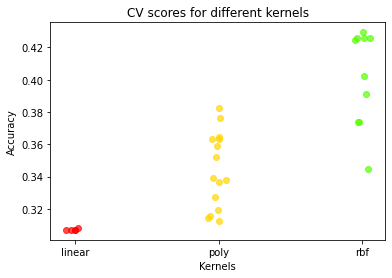

In [30]:
kernel_data = defaultdict(list)

for params, score in zip(clf.cv_results_["params"], clf.cv_results_["mean_test_score"]):
  key = params["kernel"]
  kernel_data[params["kernel"]].append(score)

kernels, scores = kernel_data.keys(), kernel_data.values()

n_categories = len(scores)
clevels = np.linspace(0., 1., n_categories)
for (idx, category_scores), clevel in zip(enumerate(scores), clevels):
  for score in category_scores:
    plt.scatter(
        np.random.normal(idx + 1, 0.04),
        score,
        color=cm.prism(clevel),
        alpha=0.7
    )

plt.xticks(range(1, len(kernels) + 1), kernels)
plt.xlabel("Kernels")
plt.ylabel("Accuracy")
plt.title("CV scores for different kernels")
plt.show()

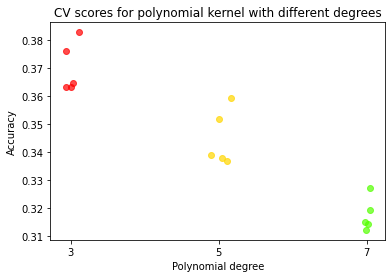

In [31]:
poly_data = defaultdict(list)

for params, score in zip(clf.cv_results_["params"], clf.cv_results_["mean_test_score"]):
  if params["kernel"] != "poly":
    continue
  poly_data[params["degree"]].append(score)

degrees, scores = poly_data.keys(), poly_data.values()

n_categories = len(scores)
clevels = np.linspace(0., 1., n_categories)
for (idx, category_scores), clevel in zip(enumerate(scores), clevels):
  for score in category_scores:
    plt.scatter(
        np.random.normal(idx + 1, 0.04),
        score,
        color=cm.prism(clevel),
        alpha=0.7
    )
    
plt.xticks(range(1, len(degrees) + 1), degrees)
plt.xlabel("Polynomial degree")
plt.ylabel("Accuracy")
plt.title("CV scores for polynomial kernel with different degrees")
plt.show()

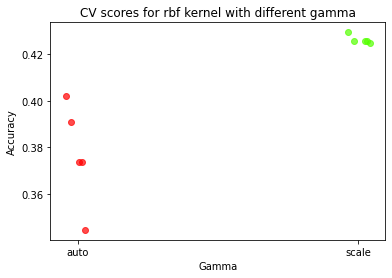

In [32]:
rbf_data = defaultdict(list)

for params, score in zip(clf.cv_results_["params"], clf.cv_results_["mean_test_score"]):
  if params["kernel"] != "rbf":
    continue
  rbf_data[params["gamma"]].append(score)

gammas, scores = rbf_data.keys(), rbf_data.values()

n_categories = len(scores)
clevels = np.linspace(0., 1., n_categories)
for (idx, category_scores), clevel in zip(enumerate(scores), clevels):
  for score in category_scores:
    plt.scatter(
        np.random.normal(idx + 1, 0.04),
        score,
        color=cm.prism(clevel),
        alpha=0.7
    )
    
plt.xticks(range(1, len(gammas) + 1), gammas)
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.title("CV scores for rbf kernel with different gamma")
plt.show()